## Project 4: Advanced Lane Finding

This writeup describes how I approached Project 4: Advanced Lane Finding. The general process for detecting lanes in images of a video stream include the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images. This step is done once to allow distortion correction to be applied to all images. The remaining steps are applied to each video image.
1. Apply the distortion correction to the image.
1. Apply a perspective transform to rectify the undistorted image ("birds-eye view").
1. Use color transforms, gradients, etc., to create a thresholded binary image that identifies the lane lines.
1. Detect lane pixels and fit a polynomial to them to find the lane boundary.
1. Determine the curvature of the lane and vehicle position with respect to center.
1. Warp the detected lane boundaries back onto the original image.
1. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

Note: I chose to rectify the image prior to applying the color transforms to identify potential lane lines. 

### 1. Camera Calibration

The camera calibration code is contained in the file ```calibrate.py```. The calibration is done by mapping chessboard corners detected in a series of calibration images to the same set of equally spaced points on a plane. From this, OpenCV can build the calibration matrix and the distortion coefficients.

The results of the calibration, the calibration matrix and the distortion coefficients, are written to a pickle file for use in subsequent image processing. The ```Undistorter``` class in file ```find_lanes.py``` is constructed with the pickle file and can be used to undistort camera images as necessary.

The following images show a distorted and undistorted chessboard image.


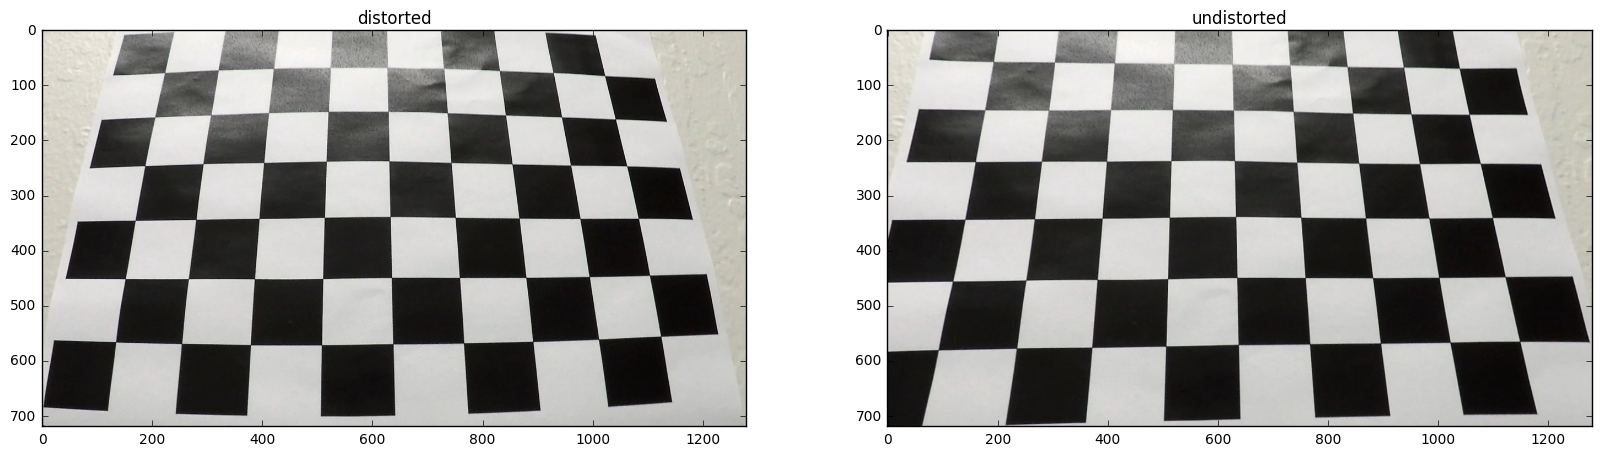

In [1]:
from find_lanes import Undistorter
from find_lanes import imread
from find_lanes import plot_images
%matplotlib inline 

undistorter = Undistorter('camera_cal/distortion_pickle.p')

chessboard = imread('camera_cal/calibration3.jpg')

chessboard_und = undistorter.undistort(chessboard)

plot_images([('distorted',chessboard),('undistorted', chessboard_und)])

## Pipeline (Test Images)

### 1. Distortion-corrected Image

The following is an example of a distorted and undistorted test image.

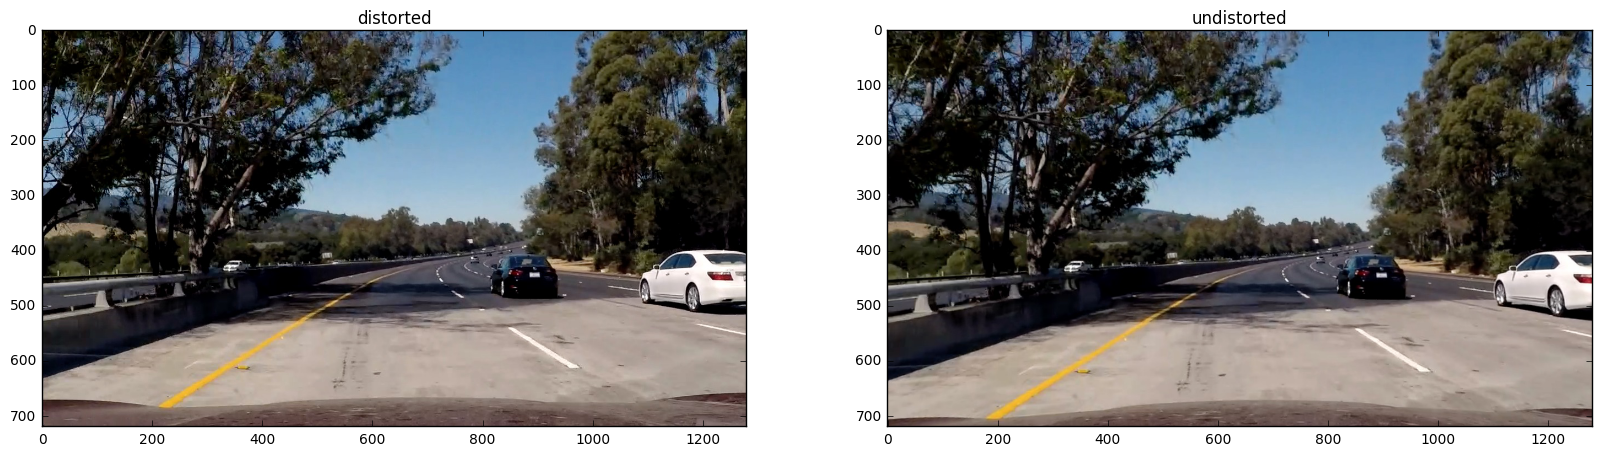

In [2]:
test5 = imread('test_images/test5.jpg')
test5_und = undistorter.undistort(test5)
plot_images([('distorted',test5),('undistorted', test5_und)])


### 2. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The perspective transform is accomplished by generating a transform matrix using OpenCV ```getPerspectiveTransform``` method. This method accepts 4 points from the source perspective and 4 correpsonding points from the target perspective and generates a transform matrix.

The transform matrix is then used by the Open CV ```warpPerspective``` method to apply the transformation to an image.

The class ```PerspectiveTransformer``` in the file ```find_lanes.py``` encapsulates this behavior. The following image shows the use of this class applied to a test image with straight lines.

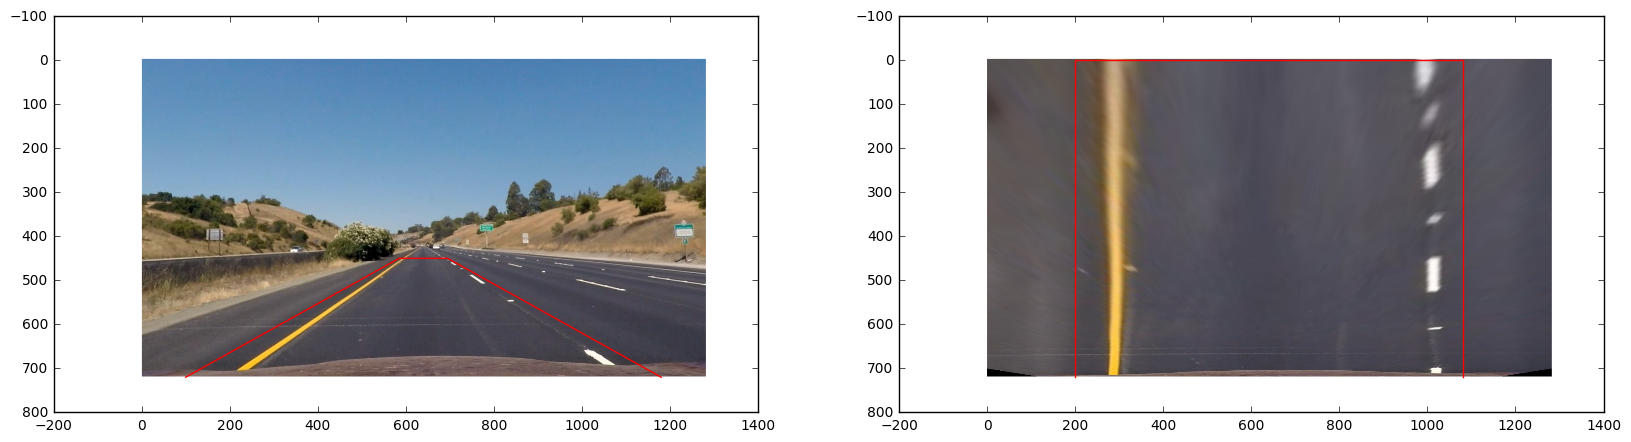

In [6]:
import numpy as np
from find_lanes import PerspectiveTransformer
import matplotlib.pyplot as plt

src = np.float32(
    [[100,720],
     [585,450],
     [695,450],
     [1180,720]]
    )
dest = np.float32(
    [[200,720],
     [200,0],
     [1080,0],
     [1080,720]]
    )


per_trans = PerspectiveTransformer(src, dest, (1280,720))

straight1 = imread('test_images/straight_lines1.jpg')
straight1_und = undistorter.undistort(straight1)
straight1_pt = per_trans.transform(straight1_und)

f, axes = plt.subplots(1, 2,figsize=(20,10))
axes[0].imshow(straight1_und)
axes[0].plot(src[:,0],src[:,1], 'r')
axes[1].imshow(straight1_pt)
axes[1].plot(dest[:,0],dest[:,1],'r')


### 3. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

To identify lane pixels, I used color bands from 3 different color spaces. Specifically, I used the histogram-equalized value of the following bands:

1. R band of the RGB color space
1. V band of the HSV color space
1. L band of the LAB color space

For each band the values 252-255 were included in the filtered image.

This is implemented in the ```filter_image``` method of the file ```find_lanes.py```. It is illustrated below.

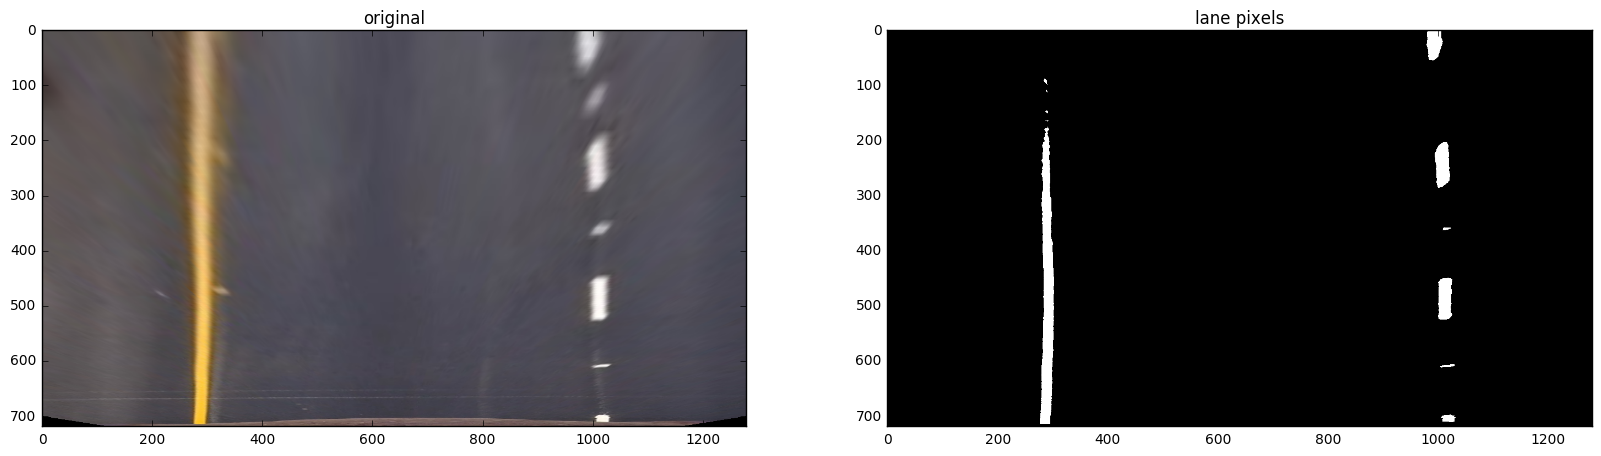

In [4]:
from find_lanes import filter_image

lanes = filter_image(straight1_pt)
plot_images([('original',straight1_pt),('lane pixels', lanes)])


### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial.

The lane-line pixels and the line fit are done in two steps, each of which will be described below.

#### Identifying Lane-line Pixels

To identify lane-line pixels in a binary image, the image is processed from bottom (closest to the car) to the top (farthest from the car). Processing each line starts with a prior estimate of the center of the lane line of the form (C,W), where C is center of the lane line and W is a window around C, the size of which indicates the level of confidence that C is the correct lane line position: a smaller W value indicates higher confidence and a larger W value indicates lower confidence.

1. In the image row, find all lane-line pixels that fall within the (C,W) window.
1. If the window contains possible lane-line pixels, then:
  1. Set C to the center of mass of the identified lane line pixels.
  1. Set W to its minimum value, indicating that we are confident that we have good line position.
1. If the window does not contain lane-line pixels, then:
  1. Let C keep its current value.
  1. Increase the size of the window W by a fixed amount indicating that our confidence is decreased.
1. Proceed to the next line in the image.

As the processing of the image proceeds, if we see lane-line pixels, our confidence remains high and we can continue to focus on a smaller portion of the image line centered around a known point. If we don't see lane-line pixels, our confidence lessens and we need to expand the portion of the next image line we are considering. This helps accomodate dashed lines that curve.

##### Initial C Value

The value of C used for the first row of an image is determined as follows:

1. If the previous frame resulted in found lane lines, then the initial C value is estimated from the identified lane lines.
1. If no lane lines were found in the previous 2 frames, then the initial C is estimated from image column histogram values for the lower half of the binary image.

This is implemented in the ```Lane.find_lane``` method in the file ```find_lanes.py```.

#### Fitting a Polynomial

After lane-line pixels have been detected, a polynomial is fit to the lane lines using the ```numpy``` ```polyfit``` method. This is implemented in the ```Lane.fit_lane``` method in the file ```find_lanes.py```.


### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

The radius of curvature is calculated in meters for each lane line (left and right) based on the polynomial fit. The calculation is based on the formula provided in the lectures.

The position of the vehicle with respect to center is calculated as follows:

```
position = (center_of_camera - center_of_lane)*(x_m_per_pixel)
```

Where:

* ```center_of_camera``` is defined as ```image_width/2``` and is assumed to be aligned to the center of the car.
* ```center_of_lane``` is defined as ```left_lane_pos + ((right_lane_pos - left_lane_pos)/2)```

This is implemented in the ```Lane.add_fit``` method.

### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.



start: 285, 1010

curvature:        2645.456|  3113.079
bad/max/total: 0/0/0


/home/jim/workspace/advancedlanes/find_lanes.py:390: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  success = right_fit != None and left_fit != None and \


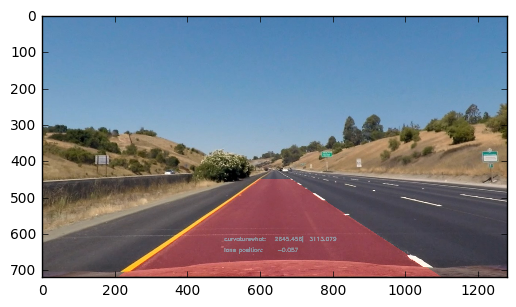

In [5]:
from find_lanes import Lane
import cv2

lane = Lane(per_trans)
lane.process_lanes(lanes)
overlay_img = lane.generate_overlay()
result = cv2.addWeighted(straight1_und, 1, overlay_img, 0.3, 0)
plt.imshow(result)


### 7. Provide a link to your final video output.

Here it is... 

### 8. Briefly discuss any problems / issues you faced in your implementation of this project.

The most difficult part of this project was the correct detection of lane lines in varying conditions from the image data. Lane-line pixel detection is really a classification problem. I think that even some simple supervised classification techcniques could be employed to search through the available data and optimize lane extraction.

The next issue is identifying the lane-line pixels from a classified image. My approach was to search within a window of assuming the entire window has equal probability. I think this could be optimized by allowing the probability in the window to decrease from the previous know position outwards toward the image edges.

In a real-world example, I would expect to have additional data that could be used to represent the prior expectations of the line locations. For example, real-time GPS and map location data would indicate the shape of the approaching roadway, which can help for expectations of where to find line lines. 
